In [1]:
import pandas as pd
import sys
import pysam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#notice: this toolbox coming from https://github.com/huangyh09/brie/blob/master/brie/utils/sam_utils.py (Yuanhua Huang)
# Here I will not use brie.utils.fetch_reads, because it will install tensorflow, which lost a lots of time. 


global CACHE_CHROM
global CACHE_SAMFILE
CACHE_CHROM = None
CACHE_SAMFILE = None

def check_pysam_chrom(samFile, chrom=None):
    """Chech if samFile is a file name or pysam object, and if chrom format. 
    """
    global CACHE_CHROM
    global CACHE_SAMFILE

    if CACHE_CHROM is not None:
        if (samFile == CACHE_SAMFILE) and (chrom == CACHE_CHROM):
            return CACHE_SAMFILE, CACHE_CHROM

    if type(samFile) == str or type(samFile) == numpy.str_:
        ftype = samFile.split(".")[-1]
        if ftype != "bam" and ftype != "sam" and ftype != "cram" :
            print("Error: file type need suffix of bam, sam or cram.")
            sys.exit(1)
        if ftype == "cram":
            samFile = pysam.AlignmentFile(samFile, "rc")
        elif ftype == "bam":
            samFile = pysam.AlignmentFile(samFile, "rb")
        else:
            samFile = pysam.AlignmentFile(samFile, "r")

    if chrom is not None:
        if chrom not in samFile.references:
            if chrom.startswith("chr"):
                chrom = chrom.split("chr")[1]
            else:
                chrom = "chr" + chrom
        if chrom not in samFile.references:
            print("Can't find references %s in samFile" %chrom)
            return samFile, None

    CACHE_CHROM = chrom
    CACHE_SAMFILE = samFile
    return samFile, chrom
    

In [3]:
def load_samfile(samFile, chrom=None):
    """Chech if samFile is a file name or pysam object, and if chrom format.
    """
    print('Warning: The load_samfile() function is recommended to be ' + 
          'replaced by check_pysam_chrom().')

    global CACHE_CHROM
    global CACHE_SAMFILE

    # get from cache
    if CACHE_CHROM is not None:
        if (samFile == CACHE_SAMFILE) and (chrom == CACHE_CHROM):
            return CACHE_SAMFILE, CACHE_CHROM

    # open file
    if type(samFile) == str or type(samFile) == numpy.str_:
        ftype = samFile.split(".")[-1]
        if ftype != "bam" and ftype != "sam" and ftype != "cram" :
            print("Error: file type need suffix of bam, sam or cram.")
            sys.exit(1)
        if ftype == "cram":
            samFile = pysam.AlignmentFile(samFile, "rc")
        elif ftype == "bam":
            samFile = pysam.AlignmentFile(samFile, "rb")
        else:
            samFile = pysam.AlignmentFile(samFile, "r")
    else:
        print("[BRIE2] Error: unknown data type: %s" %samFile)
        print(type(samFile), type(samFile) == numpy.str_)
        sys.exit(1)

    if chrom is not None:
        if chrom not in samFile.references:
            if chrom.startswith("chr"):
                chrom = chrom.split("chr")[1]
            else:
                chrom = "chr" + chrom
        if chrom not in samFile.references:
            print("Can't find references %s in samFile" %chrom)
            return samFile, None

        CACHE_CHROM = chrom
        CACHE_SAMFILE = samFile
        return samFile, chrom
    else:
        CACHE_SAMFILE = samFile
        return samFile
        

In [4]:
def fetch_reads(samfile, chrom, start, end, rm_duplicate=True, inner_only=True,
                mapq_min=0, trimLen_max=1e6, rlen_min=1,  is_mated=True):
    """To fetch the reads in a given region from a pysam AlignmentFile.

    Args:
        samfile: A Samfile object in pysam.
        chrom: A string of chromosome, e.g., "IV", "chr10".
        start: An integer of the start position for mapped reads.
        end: An integer of the end position for mapped reads.
        rm_duplicate: A bool for only keeping the first one of duplicates.
        inner_only: A bool for only keeping fully region matched reads.
        mapq_min: An integer of the minimum of map quality.
        trimLen_max: An integer of the maximum length of trimmed bases.
        rlen_min: An integer of the minimum of read length.
        is_paired: A bool for mating paired-end reads.

    Returns:
        A dict containing lists of mated reads1 and reads2, and unmated reads1u
        and reads2u, i.e.,
        {'reads1': [r11, r21, ...]
         'reads2': [r12, r22, ...]
         'reads1u': [r*1, r*1, ...]
         'reads2u': [r*2, r*2, ...]}
        reads1 is the 5-end of the fragment, and reads2 is the 3-end of the 
        fragment.

    Raises:
        ValueError: An error occurred when fetching reads.
        AssertionError: An error occurred when fetching reads.
    """
    #part 1. check the input and fetch the reads
    chrom  = str(chrom)
    if chrom in samfile.references:
        pass
    else:
        chrom_parts = chrom.split("chr")
        if len(chrom_parts) <= 1:
            chrom = chrom_parts[0]
        else:
            chrom = chrom_parts[1]

    try:
        reads = samfile.fetch(chrom, start, end)
    except ValueError:
        reads = []
        print("Cannot fetch reads in region: %s:%d-%d" %(chrom, start, end))
    except AssertionError:
        reads = []
        print("AssertionError in region: %s:%d-%d" %(chrom, start, end))
        print(" - Check that your BAM file is indexed!")

    #part 2. get reads and filter some of them
    qname1, qname2 = [], []
    reads1, reads2 = [], []
    r_prev = None
    for r in reads:
        # filter 4: only keep the first one of duplicates
        if (rm_duplicate and r_prev is not None and r_prev.qname == r.qname and 
            r_prev.positions == r.positions): r_prev = r; continue
        r_prev = r
        # filter 1: only particially mapped to the regions
        if inner_only == True and (r.pos is None or r.pos < start or 
                                   r.aend is None or r.aend > end): continue
        # filter 2: too low map quality
        if r.mapq < mapq_min: continue
        # filter 3: too long trimmed bases
        if r.rlen - len(r.positions) > trimLen_max: continue
        # filter 5: too short mapped length
        if len(r.positions) < rlen_min: continue
        
        if r.is_read2:
            reads2.append(r)
            qname2.append(r.qname)
        else:
            reads1.append(r)
            qname1.append(r.qname)

    #part 2.1 chech the mate reads' query
    FLAG = True
    if len(qname1) > 0:
        for i in range(len(qname1)-1):
            if qname1[i][-1] != qname1[i+1][-1]:
                FLAG = False
                break
    if FLAG and len(qname2) > 0:
        for i in range(len(qname1)-1):
            if qname1[i][-1] != qname1[i+1][-1]:
                FLAG = False
                break

    if FLAG:
        for i in range(len(qname1)):
            qname1[i] = qname1[i][:-1]
        for i in range(len(qname2)):
            qname2[i] = qname2[i][:-1]


    # part 3. mate the reads
    rv_reads1, rv_reads2 = [], []
    rv_reads1u, rv_reads2u = [], []
    if is_mated == True:
        idx1 = sorted(range(len(qname1)), key=qname1.__getitem__)
        idx2 = sorted(range(len(qname2)), key=qname2.__getitem__)

        i1, i2 = 0, 0
        while i1 < len(idx1) and i2 < len(idx2):
            if qname1[idx1[i1]] == qname2[idx2[i2]]:
                rv_reads1.append(reads1[idx1[i1]])
                rv_reads2.append(reads2[idx2[i2]])
                i1, i2 = i1 + 1, i2 + 1
            elif qname1[idx1[i1]] < qname2[idx2[i2]]:
                rv_reads1u.append(reads1[idx1[i1]])
                i1 += 1
            elif qname1[idx1[i1]] > qname2[idx2[i2]]:
                rv_reads2u.append(reads2[idx2[i2]])
                i2 += 1
        for i in range(i1, len(idx1)):
            rv_reads1u.append(reads1[idx1[i]])
        for i in range(i2, len(idx2)):
            rv_reads2u.append(reads2[idx2[i]])
    else:
        rv_reads1u, rv_reads2u = reads1, reads2

    # part 4. return reads
    RV = {}
    RV["reads1"] = rv_reads1
    RV["reads2"] = rv_reads2
    RV["reads1u"] = rv_reads1u
    RV["reads2u"] = rv_reads2u
    return RV

In [6]:
refdf=pd.read_csv('/mnt/ruiyanhou/nfs_share2/three_primer/PBMC/run_scTail/PBMC866_GXfiltered_without_umitools/ref_file/ref_gene.tsv',delimiter='\t')
refdf['PAS']=np.where(refdf['Strand']=='+',refdf['End'],refdf['Start'])
refdf

,Chromosome,Feature,Start,End,Strand,gene_id,gene_name,PAS
0,chr1,gene,11868,14409,+,ENSG00000290825.1,DDX11L2,14409
1,chr1,gene,12009,13670,+,ENSG00000223972.6,DDX11L1,13670
2,chr1,gene,29553,31109,+,ENSG00000243485.5,MIR1302-2HG,31109
3,chr1,gene,30365,30503,+,ENSG00000284332.1,MIR1302-2,30503
4,chr1,gene,52472,53312,+,ENSG00000268020.3,OR4G4P,53312
...,...,...,...,...,...,...,...,...
62576,chrY,gene,26626519,26627159,-,ENSG00000231514.1,CCNQP2,26626519
62577,chrY,gene,57015104,57016096,-,ENSG00000292364.1,AMD1P2,57015104
62578,chrY,gene,57165511,57165845,-,ENSG00000292367.1,ELOCP24,57165511
62579,chrY,gene,57171889,57172769,-,ENSG00000292368.1,TRPC6P1,57171889


In [7]:
transcriptdf=pd.read_csv('/mnt/ruiyanhou/nfs_share2/annotation/annotation_from_Gencode/one_transcript_gene.tsv',delimiter='\t')
transcriptdf

,Chromosome,Start,End,Strand,gene_id,transcript_id,gene_name,transcript_name
0,chr1,11868,14409,+,ENSG00000290825.1,ENST00000456328.2,DDX11L2,DDX11L2-202
1,chr1,12009,13670,+,ENSG00000223972.6,ENST00000450305.2,DDX11L1,DDX11L1-201
2,chr1,30365,30503,+,ENSG00000284332.1,ENST00000607096.1,MIR1302-2,MIR1302-2-201
3,chr1,52472,53312,+,ENSG00000268020.3,ENST00000606857.1,OR4G4P,OR4G4P-201
4,chr1,57597,64116,+,ENSG00000290826.1,ENST00000642116.1,ENSG00000290826,ENST00000642116
...,...,...,...,...,...,...,...,...
38675,chrY,57015104,57016096,-,ENSG00000292364.1,ENST00000711258.1,AMD1P2,AMD1P2-202
38676,chrY,57165511,57165845,-,ENSG00000292367.1,ENST00000711266.1,ELOCP24,ELOCP24-202
38677,chrY,57171889,57172769,-,ENSG00000292368.1,ENST00000711267.1,TRPC6P1,TRPC6P1-202
38678,chrY,57201142,57203357,-,ENSG00000292370.1,ENST00000711269.1,WASIR1,WASIR1-202


In [8]:
selectdf=refdf[(refdf['gene_id'].isin(transcriptdf['gene_id']))]
selectdf

,Chromosome,Feature,Start,End,Strand,gene_id,gene_name,PAS
0,chr1,gene,11868,14409,+,ENSG00000290825.1,DDX11L2,14409
1,chr1,gene,12009,13670,+,ENSG00000223972.6,DDX11L1,13670
3,chr1,gene,30365,30503,+,ENSG00000284332.1,MIR1302-2,30503
4,chr1,gene,52472,53312,+,ENSG00000268020.3,OR4G4P,53312
5,chr1,gene,57597,64116,+,ENSG00000290826.1,ENSG00000290826,64116
...,...,...,...,...,...,...,...,...
62576,chrY,gene,26626519,26627159,-,ENSG00000231514.1,CCNQP2,26626519
62577,chrY,gene,57015104,57016096,-,ENSG00000292364.1,AMD1P2,57015104
62578,chrY,gene,57165511,57165845,-,ENSG00000292367.1,ELOCP24,57165511
62579,chrY,gene,57171889,57172769,-,ENSG00000292368.1,TRPC6P1,57171889


In [9]:
plt.rcParams['font.size'] = 18

In [10]:
import warnings
warnings.filterwarnings('ignore')

bamFile='/mnt/ruiyanhou/nfs_share2/three_primer/PBMC/preprocess/STAR_output/PBMC866_umitools_filtered.bam'

In [11]:
onegenedf=selectdf[selectdf['gene_name']=='S100A9']
onegenedf

,Chromosome,Feature,Start,End,Strand,gene_id,gene_name,PAS
1739,chr1,gene,153357853,153361023,+,ENSG00000163220.11,S100A9,153361023


1739
chr1
9755 reads1 in pair; 9755 reads2 in pair; 15 reads1 is unique; 954 reads2 is unique


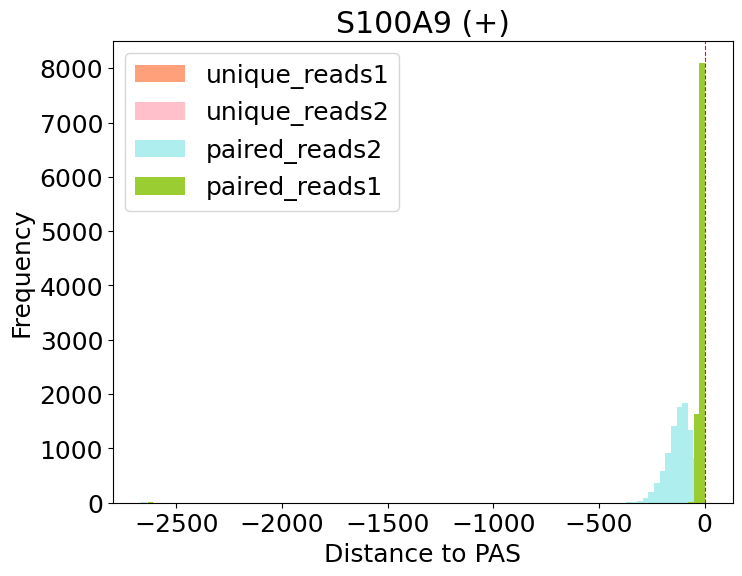

In [12]:
for index, row in onegenedf.iterrows():
    print(index)
    print(row['Chromosome'])
    samFile, _chrom = check_pysam_chrom(bamFile, row['Chromosome'])
    reads = fetch_reads(samFile, _chrom,  row['Start'] , row['End'],  trimLen_max=100)

    reads1_paired=reads['reads1']
    reads2_paired=reads['reads2']
    reads1_unique=reads['reads1u']
    reads2_unique=reads['reads2u']


    GAPDHreads1_paired=[read for read in reads1_paired if read.get_tag('GX')==row['gene_id']]
    GAPDHreads2_paired=[read for read in reads2_paired if read.get_tag('GX')==row['gene_id']]
    GAPDHreads1_unique=[read for read in reads1_unique if read.get_tag('GX')==row['gene_id']]
    GAPDHreads2_unique=[read for read in reads2_unique if read.get_tag('GX')==row['gene_id']]

    print('{} reads1 in pair; {} reads2 in pair; {} reads1 is unique; {} reads2 is unique'.format(len(GAPDHreads1_paired),len(GAPDHreads2_paired),len(GAPDHreads1_unique),len(GAPDHreads2_unique)))
    
    reads1_paired_end=[read.reference_end for read in GAPDHreads1_paired]
    reads2_paired_end=[read.reference_end for read in GAPDHreads2_paired]
    reads1_unique_end=[read.reference_end for read in GAPDHreads1_unique]
    reads2_unique_end=[read.reference_end for read in GAPDHreads2_unique]

    
    # fig,ax=plt.subplots()
    # plt.hist(reads1_unique_end,bins=100,color='lightsalmon',label='reads1_unique')
    # plt.hist(reads2_unique_end,bins=100,color='pink',label='reads2_unique')
    # plt.hist(reads2_paired_end,bins=100,color='paleturquoise',label='reads2_paired')
    # plt.hist(reads1_paired_end,bins=100,color='yellowgreen',label='reads1_paired')
    
    # ax.axvline(x=row['PAS'], color='r', linestyle='--',lw=0.8)  
    # plt.legend()
    # genetitle=row['gene_name']+' '+'('+row['Strand']+')'
    # plt.title(genetitle)
    # plt.show()


    reads1_paired_fragement=[read.reference_end-row['PAS'] for read in GAPDHreads1_paired]
    reads2_paired_fragement=[read.reference_end-row['PAS'] for read in GAPDHreads2_paired]
    reads1_unique_fragement=[read.reference_end-row['PAS'] for read in GAPDHreads1_unique]
    reads2_unique_fragement=[read.reference_end-row['PAS'] for read in GAPDHreads2_unique]



    fig,ax=plt.subplots(figsize=(8,6))
    
    plt.hist(reads1_unique_fragement,bins=100,color='lightsalmon',label='unique_reads1')
    plt.hist(reads2_unique_fragement,bins=100,color='pink',label='unique_reads2')
    plt.hist(reads2_paired_fragement,bins=100,color='paleturquoise',label='paired_reads2')
    plt.hist(reads1_paired_fragement,bins=100,color='yellowgreen',label='paired_reads1')

    plt.ylabel('Frequency')
    plt.xlabel('Distance to PAS')

    plt.xticks()
    plt.yticks()
        
    ax.axvline(x=0, color='r', linestyle='--',lw=0.8)  
    plt.legend()
    genetitle=row['gene_name']+' '+'('+row['Strand']+')'
    plt.title(genetitle)
    #fig.savefig('/mnt/ruiyanhou/nfs_share2/three_primer/plot_example/S100A9_histogram.pdf',dpi=300,bbox_inches='tight')
    plt.show()

    

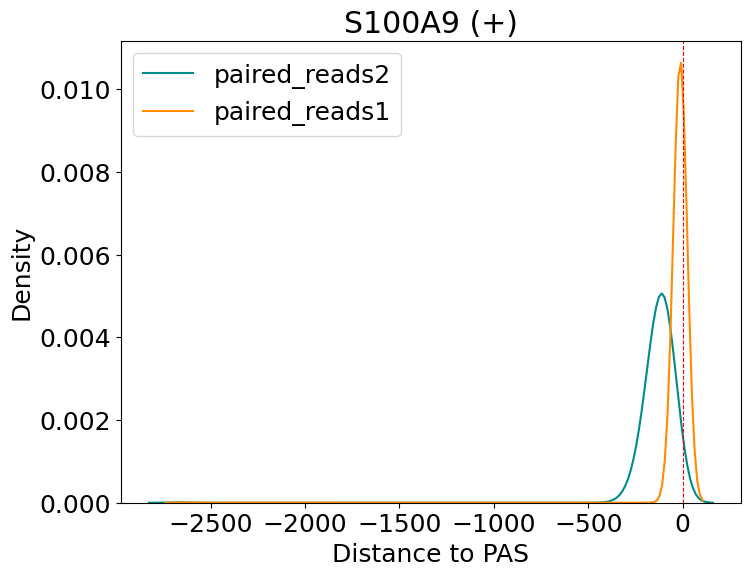

In [13]:
    

    fig,ax=plt.subplots(figsize=(8,6))
    # sns.kdeplot(np.array(reads1_unique_fragement), bw=0.5,color='dodgerblue',label='unique_reads1')
    # sns.kdeplot(np.array(reads2_unique_fragement), bw=0.5,color='brown',label='unique_reads2')
    sns.kdeplot(np.array(reads2_paired_fragement), bw=0.5,color='darkcyan',label='paired_reads2')
    sns.kdeplot(np.array(reads1_paired_fragement), bw=0.5,color='darkorange',label='paired_reads1')

    plt.xlabel('Distance to PAS')
    plt.ylabel('Density')
    plt.xticks()
    plt.yticks()

    ax.axvline(x=0, color='r', linestyle='--',lw=0.8)  
    plt.legend()
    genetitle=row['gene_name']+' '+'('+row['Strand']+')'
    plt.title(genetitle)
    #fig.savefig('/mnt/ruiyanhou/nfs_share2/three_primer/plot_example/S100A9_density_total.pdf',bbox_inches='tight',dpi=300)
    plt.show()

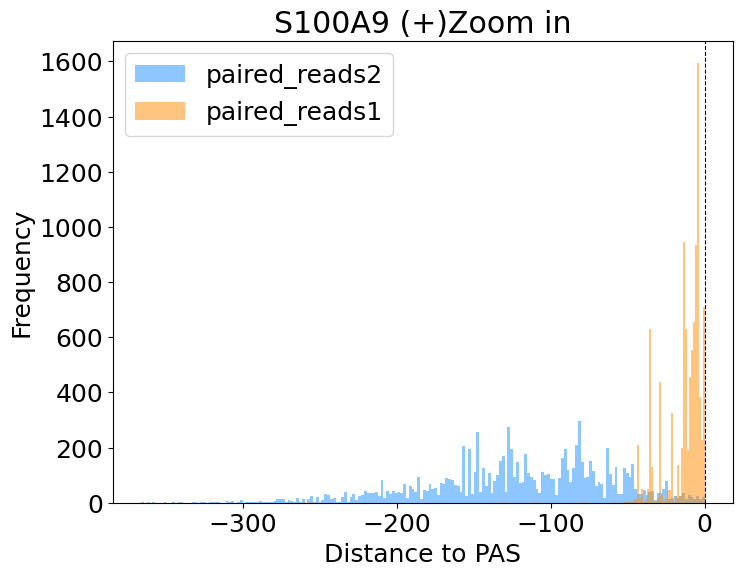

In [14]:
    # select_reads1_unique_fragement=[fragement for fragement in reads1_unique_fragement if np.abs(fragement)<1000]
    # select_reads2_unique_fragement=[fragement for fragement in reads2_unique_fragement if np.abs(fragement)<1000]
    select_reads1_paired_fragement=[fragement for fragement in reads1_paired_fragement if np.abs(fragement)<1000]
    select_reads2_paired_fragement=[fragement for fragement in reads2_paired_fragement if np.abs(fragement)<1000]


    fig,ax=plt.subplots(figsize=(8,6))
    # sns.kdeplot(np.array(select_reads1_unique_fragement), bw=0.5,color='black',label='unique_reads1')
    # sns.kdeplot(np.array(select_reads2_unique_fragement), bw=0.5,color='gold',label='unique_reads2')
    # sns.kdeplot(np.array(select_reads2_paired_fragement), bw=0.5,color='darkcyan',label='paired_reads2')
    # sns.kdeplot(np.array(select_reads1_paired_fragement), bw=0.5,color='darkorange',label='paired_reads1')
    plt.hist(np.array(select_reads2_paired_fragement), color='dodgerblue',label='paired_reads2',alpha=0.5,bins=200)
    plt.hist(np.array(select_reads1_paired_fragement), color='darkorange',label='paired_reads1',alpha=0.5,bins=200)

    

    plt.xlabel("Distance to PAS")
    plt.ylabel("Frequency")
    plt.xticks()
    plt.yticks()

        
    ax.axvline(x=0, color='black', linestyle='--',lw=0.8)  
    plt.legend()
    genetitle=row['gene_name']+' '+'('+row['Strand']+')'+'Zoom in'
    plt.title(genetitle)
    #fig.savefig('/mnt/ruiyanhou/nfs_share2/three_primer/plot_example/S100A9_density_zoomin_hist.pdf',bbox_inches='tight',dpi=300)
    plt.show()

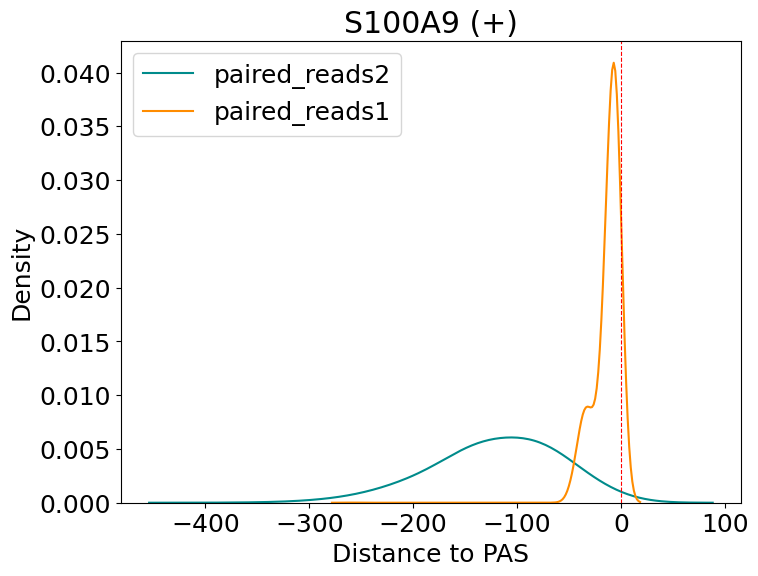

In [15]:
    fig,ax=plt.subplots(figsize=(8,6))
    # sns.kdeplot(np.array(reads1_unique_fragement), bw=0.5,color='dodgerblue',label='unique_reads1')
    # sns.kdeplot(np.array(reads2_unique_fragement), bw=0.5,color='brown',label='unique_reads2')
    sns.kdeplot(np.array(select_reads2_paired_fragement), bw=0.5,color='darkcyan',label='paired_reads2')
    sns.kdeplot(np.array(select_reads1_paired_fragement), bw=0.5,color='darkorange',label='paired_reads1')

    plt.xlabel('Distance to PAS')
    plt.ylabel('Density')
    plt.xticks()
    plt.yticks()

    ax.axvline(x=0, color='r', linestyle='--',lw=0.8)  
    plt.legend()
    genetitle=row['gene_name']+' '+'('+row['Strand']+')'
    plt.title(genetitle)
    #fig.savefig('/mnt/ruiyanhou/nfs_share2/three_primer/plot_example/S100A9_density_zoomin.pdf',bbox_inches='tight',dpi=300)
    plt.show()